## Inference

In this part of the notebook the fine-tuned model is loaded to run inference on the test set.

In [ ]:
torch.cuda.is_available()

False

In [ ]:
from transformers import SegformerForSemanticSegmentation
import torch

checkpoint_path = os.path.join(base_path, Path("trained_models/with_nonpv_color/segformer/b5/training_3"))
trained_model = os.path.join(checkpoint_path, Path("best_model_10epochs_3e-05lr_batch2.pt"))
predictions_save_path = os.path.join(checkpoint_path, "masks")
figs_save_path = os.path.join(checkpoint_path, "figs")
csv_save_path = os.path.join(checkpoint_path, "csv")

os.makedirs(predictions_save_path, exist_ok=True)
os.makedirs(figs_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

# ADE20K b5 / b1
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
#model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model.decode_head.classifier = torch.nn.Conv2d(
    in_channels=768, # 256 # This should match the output channels from the previous layer
    out_channels=2,    # Change to 2 for binary segmentation
    kernel_size=(1, 1)
)

model.load_state_dict(torch.load(trained_model))
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

  0%|          | 0/105 [00:00<?, ?it/s]c:\Users\panag\anaconda3\envs\torch\Lib\site-packages\datasets\features\image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
  0%|          | 0/105 [00:09<?, ?it/s]

Test_Mean_iou_TP: 0.9637783654141812
Test_Mean_iou_TPFN: 0.9637783654141812
Test_Mean_f1: 0.9815551310556477
Test_Mean_precision: 0.9903943377148635
Test_Mean_recall: 0.972872307405798
CSV files saved!


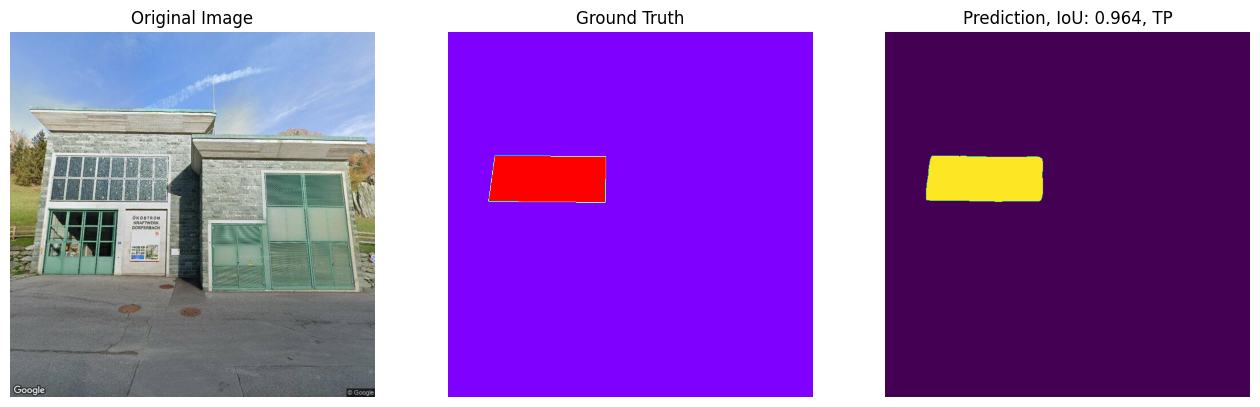

In [ ]:
import cv2
from sklearn.metrics import precision_score, recall_score

# Load the metric for evaluation
mean_iou = load("mean_iou")
precision = load("precision","multilabel")
recall = load("recall")
f1_metric = load("f1")

# Initialize lists and counters to save test data
test_ious_TP = []
test_ious_TPFN = []
test_precision = []
test_recall = []
test_f1 = []

TP = 0
TN = 0
FP = 0
FN = 0

for idx, batch in enumerate(tqdm(test_dataloader)):

    model.to(device)
    model.eval()
    with torch.no_grad():

        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        #outputs = model(pixel_values=pixel_values)
        outputs = model(pixel_values=pixel_values, labels=labels)
        logits = outputs.logits #.cpu()
        loss = outputs.loss #.cpu()


        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

        # Option 1: Get the predicted class with argmax
        #predicted = upsampled_logits.argmax(dim=1)

        # Option 2: Get the predicted probabilities and apply a threshold

        probs = torch.nn.functional.softmax(upsampled_logits, dim=1)  # Convert logits to probabilities
        confidence_threshold = 0.2  # Adjust as needed

        # Get the probability of class 1 (foreground)
        foreground_probs = probs[:, 1, :, :]

        # Apply threshold: set to 1 if prob ≥ threshold, else 0 (background)
        predicted = (foreground_probs >= confidence_threshold).long()

        predicted = predicted.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        # Save mask
        filename = str(idx) + ".png"
        cv2.imwrite(os.path.join(predictions_save_path, filename), predicted[0])

        # note that the metric expects predictions + labels as numpy arrays
        mean_iou.add_batch(predictions=predicted, references=labels)
        #precision.add_batch(predictions=[predicted], references=[labels])
        #recall.add_batch(predictions=predicted.flatten(), references=labels.flatten())
        f1_metric.add_batch(predictions=predicted.flatten(), references=labels.flatten())
        """
        # Calculate metrics
        metrics = metric._compute(num_labels=2, # len(id2label)
                        predictions=predicted.detach().cpu().numpy(),
                        references=labels.detach().cpu().numpy(),
                        ignore_index=None, #255
                        reduce_labels=False, # we've already reduced the labels before)
        )
        """
        iou_result = mean_iou.compute(num_labels=2, predictions=predicted, references=labels, ignore_index=None, reduce_labels=False)
        #precision_result = precision.compute(num_labels=2, predictions=predicted.flatten().tolist(), references=labels.flatten().tolist(), ignore_index=None, reduce_labels=False)
        #§recall_result = recall.compute(num_labels=2, predictions=predicted.flatten(), references=labels.flatten(), ignore_index=None, reduce_labels=False)
        f1_result = f1_metric.compute(predictions=predicted.flatten(), references=labels.flatten(), average="binary")


        # Check if the expected keys exist in the metrics dictionary
        iou = iou_result['per_category_iou'][1]  # Assuming class 1 is your foreground
        #precision = precision_result['precision']
        f1 = f1_result["f1"]
        precision = precision_score(labels.flatten(), predicted.flatten())
        recall = recall_score(labels.flatten(), predicted.flatten())

        if len(np.unique(labels.squeeze(0))) == 2: # if there is pv in ground truth
            if len(np.unique(predicted.squeeze(0))) == 2: # if there is pv in prediction
                test_ious_TP.append(iou)
                test_ious_TPFN.append(iou)
                TP += 1
                pred_type = "TP"
            else: # if there is no pv in prediction
                test_ious_TPFN.append(iou) # TEST: for counting
                FN += 1
                pred_type = "FN"
        else: # if ground truth has no pv
            if len(np.unique(predicted.squeeze(0))) == 2: # if there is pv in prediction
                FP += 1
                pred_type = "FP"
            else: # if there is no pv in prediction
                TN += 1
                pred_type = "TN"

        test_f1.append(f1)
        test_precision.append(precision)
        test_recall.append(recall)


        # Display the original image and the predicted segmentation map side by side
        fig, ax = plt.subplots(1, 3, figsize=(16, 8))
        ax[0].imshow(pixel_values.squeeze().permute(1,2,0).cpu().numpy())
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        ax[1].imshow(labels[0], cmap="rainbow") #.squeeze().cpu().numpy()
        ax[1].set_title("Ground Truth")
        ax[1].axis("off")

        ax[2].imshow(predicted[0]) #.squeeze().cpu().numpy()
        ax[2].set_title(f"Prediction, IoU: {round(iou,3)}, {pred_type}")
        ax[2].axis("off")
        #plt.show
        filename = str(idx) + ".png"
        plt.savefig(os.path.join(figs_save_path,filename), bbox_inches='tight')
        #break"

    #break

# Calculate Test Metrics
test_mean_iou_TP = np.mean(test_ious_TP)
test_mean_iou_TPFN = np.mean(test_ious_TPFN)
test_mean_f1 = np.mean(test_f1)
test_mean_precision = np.mean(test_precision)
test_mean_recall = np.mean(test_recall)
print("Test_Mean_iou_TP:", test_mean_iou_TP)
print("Test_Mean_iou_TPFN:", test_mean_iou_TPFN)
print("Test_Mean_f1:", test_mean_f1)
print("Test_Mean_precision:", test_mean_precision)
print("Test_Mean_recall:", test_mean_recall)


# Save metrics in a csv file
# Create a DataFrame with mean only in the first row
test_mean_column_TP = [test_mean_iou_TP] + [''] * (len(test_ious_TP) - 1)
test_mean_column_TPFN = [test_mean_iou_TPFN] + [''] * (len(test_ious_TPFN) - 1)
df = pd.DataFrame({
    'test_ious_TP': test_ious_TP,
    'test_ious_TPFN': test_ious_TPFN,
    'test_f1': test_f1,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_mean_iou_TP': test_mean_column_TP,
    'test_mean_iou_TPFN': test_mean_column_TPFN
})
csv_filename = 'test_ious.csv'
df.to_csv(os.path.join(csv_save_path, csv_filename), index=False)

# Confusion matrix
df2 = pd.DataFrame([{
    'TP': TP,
    'TN': TN,
    'FP': FP,
    'FN': FN
}])
csv_cm_filename = 'confusion_matrix.csv'
df2.to_csv(os.path.join(csv_save_path, csv_cm_filename), index=False)

print("CSV files saved!")